<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #10: Recommender Systems

<span style="color:blue; font-size: 12pt">Andrey Saitgalin </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'"> andrey.saitgalin@gmail.com </span>

<h1 align="center">Organization Info</h1> 

* Дедлайн **18 декабря 23:59** для всех групп.
* В качестве решения задания нужно прислать ноутбук с подробными комментариями (<span style='color:red'> без присланного решения результат контеста не будет засчитан </span>).
* <span style='color:red'>Название команды в контесте должно соответствовать шаблону: НомерГруппы_Имя_Фамилия, например, 494_Ivan_Ivanov</span>.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task10.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``


--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было.

Считаем данные

In [8]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

Немного поисследуем их

In [9]:
df = pd.read_csv("data/train.csv")

In [10]:
df.head()

,rating,movieId,userId
0,3.0,2158,10953099004185006703
1,3.5,12959,10953099004185006703
2,3.5,7808,10953099004185006703
3,4.0,9049,4762492897681260571
4,3.0,12363,2110017552365950661


In [11]:
df.shape

(19014573, 3)

In [12]:
s = df.groupby("userId").size().reset_index()
s

,userId,0
0,58385675418643,369
1,276751593751957,364
2,342116415432385,24
3,346047417706179,23
4,373273979514165,250
5,396848702229459,139
6,435240480632734,225
7,755057167469224,49
8,824866491515703,129
9,1080014215384102,159


In [13]:
df['rating'].mean()

3.5207268919475605

(array([  2.00000000e+00,   7.59700000e+03,   5.47400000e+03,
          6.92500000e+03,   4.03700000e+03,   5.61100000e+03,
          3.39200000e+03,   4.53200000e+03,   2.76300000e+03,
          3.99500000e+03,   3.53800000e+03,   2.19600000e+03,
          3.14100000e+03,   2.31700000e+03,   2.93900000e+03,
          1.93100000e+03,   2.59200000e+03,   1.69900000e+03,
          2.28900000e+03,   2.15600000e+03]),
 array([  9.  ,  11.55,  14.1 ,  16.65,  19.2 ,  21.75,  24.3 ,  26.85,
         29.4 ,  31.95,  34.5 ,  37.05,  39.6 ,  42.15,  44.7 ,  47.25,
         49.8 ,  52.35,  54.9 ,  57.45,  60.  ]),
 <a list of 20 Patch objects>)

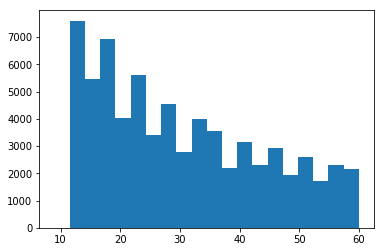

In [14]:
plt.hist(s[0][s[0] < np.percentile(s[0], 50)], bins=20)

In [15]:
group_sizes = df.groupby("movieId").size().reset_index()
blacklist = group_sizes[group_sizes[0] < 5].movieId
df = df[~df.movieId.isin(blacklist)]

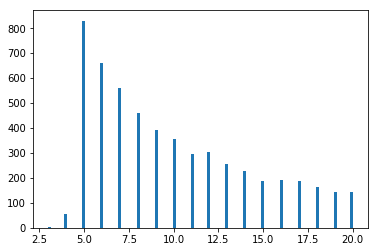

In [16]:
_ = plt.hist(group_sizes[0][group_sizes[0] < np.percentile(group_sizes[0], 30)], bins=100)

In [17]:
print("Unique user count", len(df["userId"].unique()))
print("Unique movie count", len(df["movieId"].unique()))

Unique user count 138493
Unique movie count 18285


In [18]:
index_to_item_id_mapping = [x for x in df["movieId"].sort_values().unique()]
index_to_user_id_mapping = [x for x in df['userId'].sort_values().unique()]

item_id_to_index_mapping = {}
user_id_to_index_mapping = {}

for index, value in enumerate(index_to_item_id_mapping, start=1):
    item_id_to_index_mapping[int(value)] = index

for index, value in enumerate(index_to_user_id_mapping, start=1):
    user_id_to_index_mapping[int(value)] = index


    
len(index_to_item_id_mapping)

18285

In [19]:

df = pd.DataFrame.from_records(
    {"userId": user_id_to_index_mapping[int(row.userId)], "movieId": item_id_to_index_mapping[int(row.movieId)], "rating": row.rating}
    for row in df.itertuples())

In [20]:
df = df.sort_values(['userId', 'movieId'])

In [21]:
df["random"] = np.random.random(size=(df.shape[0], 1))
idx = df.sort_values(by="random") \
    .reset_index() \
    .groupby("userId") \
    .head(n=7)["index"]

mask = df.index.isin(idx)
train_df = df[~mask]
test_df = df[mask]

In [22]:
train_df[["userId", "movieId", "rating"]].to_csv("ml20m_train.csv", header=False, index=False)
test_df[["userId", "movieId", "rating"]].to_csv("ml20m_test.csv", header=False, index=False)

In [23]:
train_df.shape, test_df.shape

((18044885, 4), (969451, 4))

In [24]:
train_df

,movieId,rating,userId,random
1435184,1,5.0,1,0.206547
8871403,2,4.0,1,0.571179
1063132,19,3.0,1,0.944995
3521760,25,4.5,1,0.753530
4850318,32,4.0,1,0.377217
18360985,34,5.0,1,0.862823
7241858,36,4.0,1,0.768003
5678468,39,4.5,1,0.523934
16825347,47,4.5,1,0.775257
18415088,103,2.5,1,0.519701


In [25]:
# test_df.sort_values('userId')
df.groupby('userId').size().sort_values()

userId
84135        9
107289      10
115866      11
105116      12
41223       12
111460      12
5798        12
108358      12
128104      12
122455      12
79871       12
38650       12
136762      12
54340       12
109532      12
4831        12
123705      12
59411       12
62549       13
62551       13
9522        13
62546       13
10581       13
62537       13
36895       13
9494        13
124761      13
36938       13
9480        13
62495       13
          ... 
41016     3488
31293     3523
21469     3589
20851     3636
12107     3652
21383     3674
83477     3697
111072    3723
115175    3769
125887    3788
130349    3795
34437     4051
121064    4075
32785     4093
9056      4173
107529    4229
64811     4264
102118    4439
66985     4599
35859     4668
100535    4739
84458     4864
109841    5161
16069     5311
59127     5373
111138    5383
124073    5438
85344     5613
22400     7493
82143     8531
Length: 138493, dtype: int64

Здесь я делал обучался на трейн-тесте, это занимает время, лучше повторно не запускать :) Убедился, что все ок и обучился на всей выборке

In [24]:
# !awk -F"," '{printf "%f |u %d |i %d\n", $3,$1,$2}' < ml20m_train.csv | \
#   vw /dev/stdin -b 25 -q ui --rank 30 --l2 0.002 --learning_rate 0.015 \
#     --passes 5 --decay_learning_rate 0.95 --power_t 0 \
#     --loss_function squared -f movielens_l2_rank30_lr_0175_b_40.reg --cache_file movielens.cache

creating quadratic features for pairs: ui 
using l2 regularization = 0.002
final_regressor = movielens_l2_rank30_lr_0175_b_40.reg
Num weight bits = 25
learning rate = 0.015
initial_t = 1
power_t = 0
decay_learning_rate = 0.95
using cache_file = movielens.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
22.681019 22.681019            1            1.0   5.0000   0.2375       63
18.185947 13.690875            2            2.0   4.0000   0.2999       63
14.862506 11.539065            4            4.0   4.5000   0.4754       63
14.516809 14.171112            8            8.0   4.5000   0.7547       63
10.088139 5.659469           16           16.0   3.5000   1.1207       63
8.370547 6.652954           32           32.0   5.0000   1.8333       63
6.214449 4.058351           64           64.0   5.0000   3.1131       63
3.697885 1.18

In [25]:
print(1)

1


In [26]:
# !awk -F"," '{printf "%f |u %d |i %d\n", $3,$1,$2}' < ml20m_test.csv | \
#   vw /dev/stdin -i movielens_l2_rank30_lr_0175_b_40.reg -t

creating quadratic features for pairs: ui 
only testing
Num weight bits = 25
learning rate = 10
initial_t = 1
power_t = 0.5
using no cache
Reading datafile = /dev/stdin
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.745838 1.745838            1            1.0   4.5000   3.1787       63
1.334486 0.923134            2            2.0   3.5000   4.4608       63
0.808990 0.283493            4            4.0   3.0000   3.6057       63
0.899094 0.989198            8            8.0   4.5000   3.7319       63
0.737888 0.576683           16           16.0   5.0000   4.6083       63
0.911719 1.085550           32           32.0   2.0000   3.9749       63
0.628371 0.345023           64           64.0   4.0000   4.3230       63
0.658981 0.689591          128          128.0   2.5000   2.6082       63
0.610890 0.562799          256          256.0   2.0000   2.9946       63
0.625589 0.6

In [27]:
print(2)

2


Здесь же ради интереса запустил рекомендационный движок VW

In [37]:
!wget https://github.com/JohnLangford/vowpal_wabbit/archive/8.5.0.zip

--2017-12-16 14:12:10--  https://github.com/JohnLangford/vowpal_wabbit/archive/8.5.0.zip
Resolving github.com... 192.30.253.113, 192.30.253.112
Connecting to github.com|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/JohnLangford/vowpal_wabbit/zip/8.5.0 [following]
--2017-12-16 14:12:11--  https://codeload.github.com/JohnLangford/vowpal_wabbit/zip/8.5.0
Resolving codeload.github.com... 192.30.253.121, 192.30.253.120
Connecting to codeload.github.com|192.30.253.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: '8.5.0.zip.1'

8.5.0.zip.1             [              <=>   ]  18.45M  5.51MB/s    in 4.2s    

2017-12-16 14:12:16 (4.37 MB/s) - '8.5.0.zip.1' saved [19350154]



In [38]:
!unzip 8.5.0.zip

Archive:  8.5.0.zip
769cba5b44450401500f39ee70c0950353368cb0
   creating: vowpal_wabbit-8.5.0/
  inflating: vowpal_wabbit-8.5.0/.editorconfig  
  inflating: vowpal_wabbit-8.5.0/.gitignore  
 extracting: vowpal_wabbit-8.5.0/.gitkeep  
  inflating: vowpal_wabbit-8.5.0/.travis.yml  
  inflating: vowpal_wabbit-8.5.0/AUTHORS  
  inflating: vowpal_wabbit-8.5.0/COPYING  
  inflating: vowpal_wabbit-8.5.0/INSTALL  
  inflating: vowpal_wabbit-8.5.0/LICENSE  
  inflating: vowpal_wabbit-8.5.0/Makefile.am  
  inflating: vowpal_wabbit-8.5.0/Makefile.in  
   creating: vowpal_wabbit-8.5.0/R/
  inflating: vowpal_wabbit-8.5.0/R/example.yaml  
   creating: vowpal_wabbit-8.5.0/R/examples/
  inflating: vowpal_wabbit-8.5.0/R/examples/vw_example.R  
  inflating: vowpal_wabbit-8.5.0/R/examples/vw_example_2.R  
   creating: vowpal_wabbit-8.5.0/R/r.vw/
  inflating: vowpal_wabbit-8.5.0/R/r.vw/DESCRIPTION  
  inflating: vowpal_wabbit-8.5.0/R/r.vw/NAMESPACE  
   creating: vowpal_wabbit-8.5.0/R/r.vw/R/
  inflating:

  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/Attributes/LabelAttribute.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/ConfigInspector.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/IVowpalWabbitConverter.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/IVowpalWabbitMultiExampleSerializerCompiler.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/IVowpalWabbitSerializer.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/IVowpalWabbitSerializerCompiler.cs  
   creating: vowpal_wabbit-8.5.0/cs/cs/Serializer/Intermediate/
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/Intermediate/EnumerizedFeature.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/Intermediate/Feature.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/Intermediate/Namespace.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/Intermediate/PreHashedFeature.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/Serializer/VowpalWabbitConstants.cs  
  inflating: vowpal_wabbit-8.5.0/cs/cs/

  inflating: vowpal_wabbit-8.5.0/cs/unittest/TrainSetCs_testLdf.cs  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/VWTestHelper.cs  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/VowpalWabbit.g4  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/VowpalWabbitExampleJsonValidator.cs  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/VowpalWabbitExampleValidator.cs  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/VowpalWabbitListenerToEvents.cs  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/VowpalWabbitStdErrPerformanceStatistics.cs  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/azure.provision.ps1  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/azuredeploy.json  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/cs_unittest.csproj  
   creating: vowpal_wabbit-8.5.0/cs/unittest/json/
  inflating: vowpal_wabbit-8.5.0/cs/unittest/json/test_array.json  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/json/test_newline.json  
  inflating: vowpal_wabbit-8.5.0/cs/unittest/packages.config  
  inflating: vowpal_wabbi

  inflating: vowpal_wabbit-8.5.0/java/src/main/java/vowpalWabbit/package-info.java  
   creating: vowpal_wabbit-8.5.0/java/src/main/java/vowpalWabbit/responses/
  inflating: vowpal_wabbit-8.5.0/java/src/main/java/vowpalWabbit/responses/ActionProb.java  
  inflating: vowpal_wabbit-8.5.0/java/src/main/java/vowpalWabbit/responses/ActionProbs.java  
  inflating: vowpal_wabbit-8.5.0/java/src/main/java/vowpalWabbit/responses/ActionScore.java  
  inflating: vowpal_wabbit-8.5.0/java/src/main/java/vowpalWabbit/responses/ActionScores.java  
  inflating: vowpal_wabbit-8.5.0/java/src/main/java/vowpalWabbit/responses/Multilabels.java  
   creating: vowpal_wabbit-8.5.0/java/src/test/
   creating: vowpal_wabbit-8.5.0/java/src/test/java/
   creating: vowpal_wabbit-8.5.0/java/src/test/java/vowpalWabbit/
  inflating: vowpal_wabbit-8.5.0/java/src/test/java/vowpalWabbit/ClosingTest.java  
  inflating: vowpal_wabbit-8.5.0/java/src/test/java/vowpalWabbit/VWTestHelper.java  
   creating: vowpal_wabbit-8.5.0/

  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/optional/zeroTerminatedFloats.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/pattern.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/patternProperties.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/properties.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/ref.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/refRemote.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/required.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/type.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tests/draft4/uniqueItems.json  
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/jsonschema/tox.ini  
   creating: vowpal_wabbit-8.5.0/rapidjson/bin/types/
  inflating: vowpal_wabbit-8.5.0/rapidjson/bin/types/booleans.json  


  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/encodingstest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/filestreamtest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/fwdtest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/istreamwrappertest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/itoatest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/jsoncheckertest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/namespacetest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/ostreamwrappertest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/pointertest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/prettywritertest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/readertest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/regextest.cpp  
  inflating: vowpal_wabbit-8.5.0/rapidjson/test/unittest/schematest.cpp  
  infl

  inflating: vowpal_wabbit-8.5.0/test/train-sets/lda-2pass-hang.dat  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/library_train  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/long_line  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/marginal_features  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ml100k_small_train  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/multiclass  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/multiclass.sch  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/multilabel  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ner.cdict  
 extracting: vowpal_wabbit-8.5.0/test/train-sets/ner.pred  
 extracting: vowpal_wabbit-8.5.0/test/train-sets/ner.test.gz  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ner.tm  
 extracting: vowpal_wabbit-8.5.0/test/train-sets/ner.train.gz  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/poisson.dat  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/probabilities.dat  
  inflating: vowpal_wabbit-8.5.0/test

  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/library_train.stderr  
 extracting: vowpal_wabbit-8.5.0/test/train-sets/ref/library_train.stdout  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/log_multi.stderr  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/long_line.stderr  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/marginal.stderr  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/marginal_compete.stderr  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/marginal_test.stderr  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/mask.stderr  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/ml100k_small.stderr  
 extracting: vowpal_wabbit-8.5.0/test/train-sets/ref/ml100k_small.stdout  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/multiclass.stderr  
 extracting: vowpal_wabbit-8.5.0/test/train-sets/ref/multiclass.stdout  
  inflating: vowpal_wabbit-8.5.0/test/train-sets/ref/multilabel.stderr  
  inflating: vowpal_wabbit-8.5.0/test/trai

  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/.nuget/NuGet.exe  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/.nuget/NuGet.targets  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/Build.props  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/Makefile.am  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/Makefile.in  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/OjaNewton.cc  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/OjaNewton.h  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/accumulate.cc  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/accumulate.h  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/action_score.cc  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/action_score.h  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/active.cc  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/active.h  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/active_cover.cc  
 extracting: vowpal_wabbit-8.5.0/vowpalwabbit/active_cover.h  
  inflating: vowpal_wabbit-8.5.0/vowpalwabbit/active_interactor.cc  
  in

In [22]:
!g++ vowpal_wabbit-8.5.0/library/recommend.cc \
    -o recommend \
    -std=c++14 \
    -lvw -lboost_program_options-mt

In [23]:
df[df["userId"] == 120].head()

,movieId,rating,userId,random
15325001,144,3.0,120,0.008590
13242654,192,0.5,120,0.494184
15266636,316,5.0,120,0.426338
8032114,369,4.0,120,0.216194
5910298,428,4.5,120,0.611366


In [24]:
with open("blacklist.vw", "w") as f:
    for row in df[df["userId"] == 120].itertuples():
        f.write("|u 120 |i " + str(row.movieId) + "\n")

In [27]:
!head blacklist.vw

|u 120 |i 144
|u 120 |i 192
|u 120 |i 316
|u 120 |i 369
|u 120 |i 428
|u 120 |i 451
|u 120 |i 521
|u 120 |i 536
|u 120 |i 540
|u 120 |i 550


In [28]:
with open("items.vw", "w") as f:
    for i in range(1, len(df["movieId"].unique()) + 1):
        f.write("|i " + str(i) + "\n")

In [29]:
!head items.vw

|i 1
|i 2
|i 3
|i 4
|i 5
|i 6
|i 7
|i 8
|i 9
|i 10


In [30]:
!echo '|u 120' | ./recommend \
    --topk 10 \
    -B blacklist.vw \
    -U /dev/stdin \
    -I items.vw \
    --vwparams '-i movielens_l2_rank30_lr_0175_b_40.reg' >recommendations

creating quadratic features for pairs: ui 
Num weight bits = 25
learning rate = 10
initial_t = 1
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1

finished run
number of examples = 0
weighted example sum = 0.000000
weighted label sum = 0.000000
average loss = n.a.
total feature number = 0


In [32]:
!cat recommendations

4.05029	|u 120|i 1150
4.08113	|u 120|i 1196
4.10797	|u 120|i 10500
4.11823	|u 120|i 5895
4.12534	|u 120|i 50
4.13327	|u 120|i 2240
4.22171	|u 120|i 7315
4.25729	|u 120|i 844
4.34621	|u 120|i 316
4.3565	|u 120|i 524


In [33]:
movies = []

for line in open("recommendations"):
    movie_id = line.split()[-1]
    movies.append(int(movie_id))

In [34]:
movies

[1150, 1196, 10500, 5895, 50, 2240, 7315, 844, 316, 524]

In [38]:
# !head kaggle_data/test.csv

Id,movieId,userId
1,939,3128775
2,19,60588779
3,1213,278728
4,1141,141994
5,2935,595805
6,2467,641508
7,6616,63042
8,1162,467875
9,3439,158648


In [39]:
# !head kaggle_data/baseline.csv

Id,rating
1,4.067366454
2,3.271976716
3,3.930168977
4,3.575967198
5,3.582748159
6,2.660361842
7,3.06538973
8,3.931537909
9,3.288660114


In [40]:
!awk -F"," '{printf "%f |u %d |i %d\n", $3,$1,$2}' < ml20m_test.csv | \
  vw /dev/stdin -i movielens_l2_rank30_lr_0175_b_40.reg -t -p /dev/stdout > predictions.csv

creating quadratic features for pairs: ui 
only testing
predictions = /dev/stdout
Num weight bits = 25
learning rate = 10
initial_t = 1
power_t = 0.5
using no cache
Reading datafile = /dev/stdin
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0   5.0000   5.0000       63
0.001907 0.003814            2            2.0   5.0000   4.9382       63
1.587685 3.173463            4            4.0   4.0000   3.8624       63
1.287091 0.986498            8            8.0   4.0000   4.1078       63
1.012325 0.737559           16           16.0   3.0000   3.5713       63
0.849014 0.685702           32           32.0   3.0000   3.6227       63
0.796949 0.744884           64           64.0   3.0000   3.3905       63
0.665160 0.533372          128          128.0   1.5000   1.9050       63
0.648031 0.630902          256          256.0   3.0000   3.

# Далее идет содержательная часть решения

Посмотрел в итоге что было с айдишниками (в первом датасете была совсем беда)

In [27]:
train_df = pd.read_csv("data/train.csv")
group_sizes = train_df.groupby("movieId").size().reset_index()
blacklist = group_sizes[group_sizes[0] < 5].movieId
train_df = train_df[~train_df.movieId.isin(blacklist)]

In [28]:
train_n = len(train_df)

In [30]:
test_df = pd.read_csv("data/test.csv")

In [31]:
bad_ids = []
for row in test_df.itertuples():
#     print(row)
    try:
        float(row.movieId)
        float(row.userId)
    except:
        bad_ids.append(row.Id)

In [32]:
bad_ids

[]

In [33]:
train_df.head(2)

,rating,movieId,userId
0,3.0,2158,10953099004185006703
1,3.5,12959,10953099004185006703


In [34]:
test_df['Id'] = [np.nan] * len(test_df)

In [35]:
test_df = test_df.rename_axis({'Id':'rating'}, axis=1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """Entry point for launching an IPython kernel.


## Объединяем трейн и тест

In [36]:
df = pd.concat([train_df, test_df], ignore_index=True, axis=0)

In [37]:
df.shape

(19983787, 3)

In [38]:
train_df.shape

(19014336, 3)

In [39]:
test_df.shape

(969451, 3)

In [40]:
test_df.shape[0] + train_df.shape[0]

19983787

In [41]:
def to_int(x):
    try:
        return int(x)
    except:
        return -1

In [42]:
s = [to_int(x) for x in df['movieId']] # чистим (для второго датасета это лишнее)

In [43]:
df['movieId'] = s

In [44]:
# df['movieId'] = df.
df.head(2)

,movieId,rating,userId
0,2158,3.0,10953099004185006703
1,12959,3.5,10953099004185006703


In [45]:
df['userId'] = [to_int(x) for x in df['userId']]

## реиндексируем выборку

In [46]:
index_to_item_id_mapping = [x for x in df["movieId"].sort_values().unique()]
index_to_user_id_mapping = [x for x in df["userId"].sort_values().unique()]

item_id_to_index_mapping = {}
user_id_to_index_mapping = {}

for index, value in enumerate(index_to_item_id_mapping, start=1):
    item_id_to_index_mapping[int(value)] = index

for index, value in enumerate(index_to_user_id_mapping, start=1):
    user_id_to_index_mapping[int(value)] = index

In [47]:
df = pd.DataFrame.from_records(
    {"userId": user_id_to_index_mapping[int(row.userId)], "movieId": item_id_to_index_mapping[int(row.movieId)], "rating": row.rating}
    for row in df.itertuples())

## возвращаем трейн и тест на место

In [48]:
df_train = df[:train_n]
df_test = df[train_n:]

In [49]:
df_train.shape, df_test.shape

((19014336, 3), (969451, 3))

In [50]:
df_train.head(3)

,movieId,rating,userId
0,2158,3.0,82143
1,12959,3.5,82143
2,7808,3.5,82143


In [51]:
df_train = df_train.sort_values(['userId', 'movieId'])

In [52]:
df_train.head(3)

,movieId,rating,userId
1435184,1,5.0,1
8871403,2,4.0,1
1063132,19,3.0,1


In [53]:
df_train[["userId", "movieId", "rating"]].to_csv("kaggle_train.csv", header=False, index=False)
df_test[["userId", "movieId", "rating"]].to_csv("kaggle_test.csv", header=False, index=False)

## делаем факторизационную машину

In [54]:
!awk -F"," '{printf "%f |u %d |i %d\n", $3,$1,$2}' < kaggle_train.csv | \
  vw /dev/stdin -b 25 -q ui --rank 30 --l2 0.002 --learning_rate 0.015 \
    --passes 5 --decay_learning_rate 0.95 --power_t 0 \
    --loss_function squared -f movielens_full_2.reg --cache_file movielens.cache

creating quadratic features for pairs: ui 
using l2 regularization = 0.002
final_regressor = movielens_full_2.reg
Num weight bits = 25
learning rate = 0.015
initial_t = 1
power_t = 0
decay_learning_rate = 0.95
creating cache_file = movielens.cache
Reading datafile = /dev/stdin
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
22.681019 22.681019            1            1.0   5.0000   0.2375       63
18.185947 13.690875            2            2.0   4.0000   0.2999       63
14.862506 11.539065            4            4.0   4.5000   0.4754       63
14.516809 14.171112            8            8.0   4.5000   0.7547       63
10.088139 5.659469           16           16.0   3.5000   1.1207       63
8.417548 6.746957           32           32.0   3.5000   1.9163       63
6.336845 4.256141           64           64.0   5.0000   3.1616       63
3.878756 1.420667          128          

В целом я игрался с параметрами (увеличивал, уменьшал lr, b, passes, decay). В целом, результат все время получался примерно один и тот же

In [56]:
test_df.head(3)

,movieId,userId,rating
0,939,3128775406573976678,NaN
1,19,6058877902987009152,NaN
2,1213,2787275058272728238,NaN


In [60]:
kaggle_test = pd.read_csv('kaggle_test.csv', header=-1)

In [62]:
kaggle_test.head(3)

,0,1,2
0,23726,939,NaN
1,45416,19,NaN
2,21152,1213,NaN


In [63]:
kaggle_test.columns = ['userId', 'movieId', 'rating']

In [64]:
u = list(set(kaggle_test['userId']))
m = list(set(kaggle_test['movieId']))

In [65]:
df_train = pd.read_csv('kaggle_train.csv', header=-1)

In [66]:
df_train.columns = ['userId', 'movieId', 'rating']

In [68]:
baseline = pd.read_csv('data/baseline.csv')

In [70]:
kaggle_test[2] = baseline['rating']

In [81]:
kaggle_test.to_csv('kaggle_test_baseline.csv', header=False, index=False)

In [82]:
!head kaggle_test_baseline.csv

23726,939,,4.067366453969999
45416,19,,3.2719767155199997
21152,1213,,3.93016897732
106470,1141,,3.5759671979800003
44653,2935,,3.5827481591300003
48049,2467,,2.66036184182
47200,6616,,3.06538973002
35115,1162,,3.93153790937
119009,3439,,3.2886601140700003
128388,7005,,3.6612360565599995


In [186]:
# train = pd.read_csv('kaggle_data/train.csv')
# test = pd.read_csv('kaggle_data/test.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
def to_int(x):
    try:
        return(int(x))
    except:
        return None

In [99]:
!awk -F"," '{printf "%f |u %d |i %d\n", $3,$1,$2}' < kaggle_test_baseline.csv | \
  vw /dev/stdin -i movielens_full_2.reg -t -p /dev/stdout > kaggle_predictions.csv

creating quadratic features for pairs: ui 
only testing
predictions = /dev/stdout
Num weight bits = 25
learning rate = 10
initial_t = 1
power_t = 0.5
using no cache
Reading datafile = /dev/stdin
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
15.213691 15.213691            1            1.0   0.0000   3.9005       63
16.838645 18.463598            2            2.0   0.0000   4.2969       63
14.885630 12.932616            4            4.0   0.0000   3.1566       63
13.037446 11.189262            8            8.0   0.0000   4.1810       63
14.598887 16.160329           16           16.0   0.0000   5.0000       63
13.243336 11.887785           32           32.0   0.0000   4.1410       63
13.441734 13.640132           64           64.0   0.0000   4.1125       63
13.484602 13.527470          128          128.0   0.0000   3.3961       63
12.986767 12.488933          256          2

In [100]:
print(1)

1


In [124]:
answers = pd.read_csv('kaggle_predictions.csv', header=-1)

In [125]:
kaggle_test.head(5)

,userId,movieId,rating,2
0,23726,939,NaN,4.067366
1,45416,19,NaN,3.271977
2,21152,1213,NaN,3.930169
3,106470,1141,NaN,3.575967
4,44653,2935,NaN,3.582748


In [126]:
answers.head(5)


,0
0,3.900473
1,4.296929
2,3.987618
3,3.156601
4,3.231710


In [127]:
baseline.shape, answers.shape

((969451, 2), (969451, 1))

In [128]:
answers.head()

,0
0,3.900473
1,4.296929
2,3.987618
3,3.156601
4,3.231710


In [129]:
answers['Id'] = baseline['Id']

In [130]:
answers['rating'] = answers[0]

In [131]:
answers = answers.drop(0, axis=1)

In [132]:
answers.to_csv("ans_kaggle.csv", index=False)

In [133]:
s = pd.read_csv('ans_kaggle.csv')

In [135]:
s.head(5)

,Id,rating
0,1,3.900473
1,2,4.296929
2,3,3.987618
3,4,3.156601
4,5,3.231710


In [112]:
ratings = np.arange(0, 5.01, 0.5)

In [113]:
@np.vectorize
def set_rating(r):
    return ratings[np.argmin(np.abs(ratings-r))]

In [114]:
delta = answers['rating'] - baseline['rating']

In [115]:
np.sqrt(np.sum(delta**2)/len(delta))

0.48313812244795462

In [116]:
answers[answers.Id.isin(bad_ids)] = baseline[baseline.Id.isin(bad_ids)]

In [117]:
answers['rating'] = set_rating(answers['rating'])

In [118]:
answers.to_csv("ans_kaggle.csv", index=False)

In [119]:
delta = answers['rating'] - baseline['rating']

In [120]:
np.sqrt(np.sum(delta**2)/len(delta))

0.504722714003493

In [121]:
!head ans_kaggle.csv

Id,rating
1,4.0
2,4.5
3,4.0
4,3.0
5,3.0
6,3.0
7,3.0
8,4.0
9,4.0


In [122]:
!head kaggle_data/baseline.csv

head: kaggle_data/baseline.csv: No such file or directory


In [123]:
baseline.head()

,Id,rating
0,1,4.067366
1,2,3.271977
2,3,3.930169
3,4,3.575967
4,5,3.582748


<h1 align="center">Contest (100%)</h1> 
* Ссылка на контест: https://www.kaggle.com/t/f37413eb448145acba822f3a8c43946d